In [1]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from dsp import *
from dtw import dtw
from tqdm.notebook import trange, tqdm
from numpy.linalg import norm
from copy import deepcopy
from IPython.display import clear_output
import librosa
from scipy.optimize import differential_evolution
import soundfile as sf
from multiprocessing import Pool
import os
plt.rcParams['figure.dpi'] = 110

Target sample rate 22050
Generator sample rate 22050


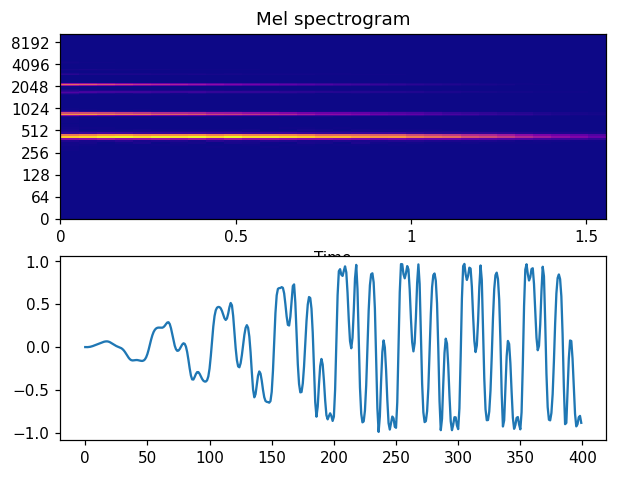

In [2]:
fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

fm_sample = Sample(fm_sample_data[100:])

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fm_sample.plot_spectrogram(ax)
ax2.plot(fm_sample.buffer[:400])

fm_sample.show_player()

22050


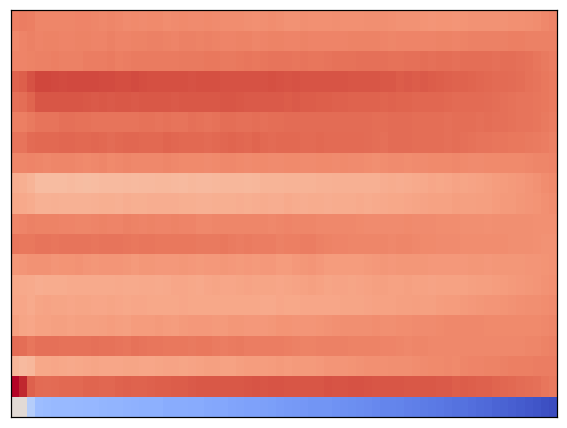

In [3]:
librosa.display.specshow(fm_sample.mfcc)
Audio(data=fm_sample.buffer, rate=SAMPLE_RATE)
print(fm_sample_sample_rate)

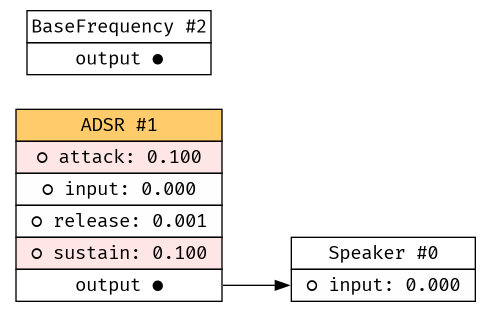

/home/wint3rmute/code/luthier/.venv/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767


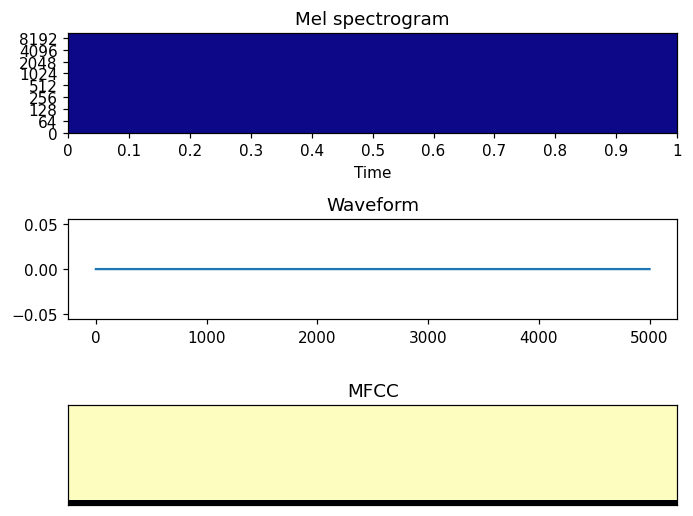

In [4]:
graph = get_starting_graph()

def add_adsr_between(graph: DspGraph, output_node: NodeId, input_node: NodeId) -> Optional[NodeId]:
    for connection in graph.connections:
        print(connection.from_node, connection.to_node, output_node, input_node)
        if connection.from_node == output_node and connection.to_node == input_node:
            print("removing")
            graph.connections.remove(connection)
            break
            
    new_adsr = graph.add_node(ADSR())
    graph.patch(output_node, "output", new_adsr, "input")
    graph.patch(new_adsr, "output", input_node, "input")
    return new_adsr
        
# adsr_addr = add_adsr_between(graph, 1, 0)
# graph.nodes[adsr_addr].inputs.attack = 0.005
# graph.nodes[adsr_addr].inputs.sustain = 0.0005
# graph.nodes[adsr_addr].inputs.release = 0.01

display(Image(graph.draw()))

generated_sample = graph.play(SAMPLE_RATE * 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_sample.plot_spectrogram(ax1)
generated_sample.plot_mfcc(ax3)
generated_sample.plot_waveform(ax2, num_samples=5000)
generated_sample.show_player()
fig.tight_layout()

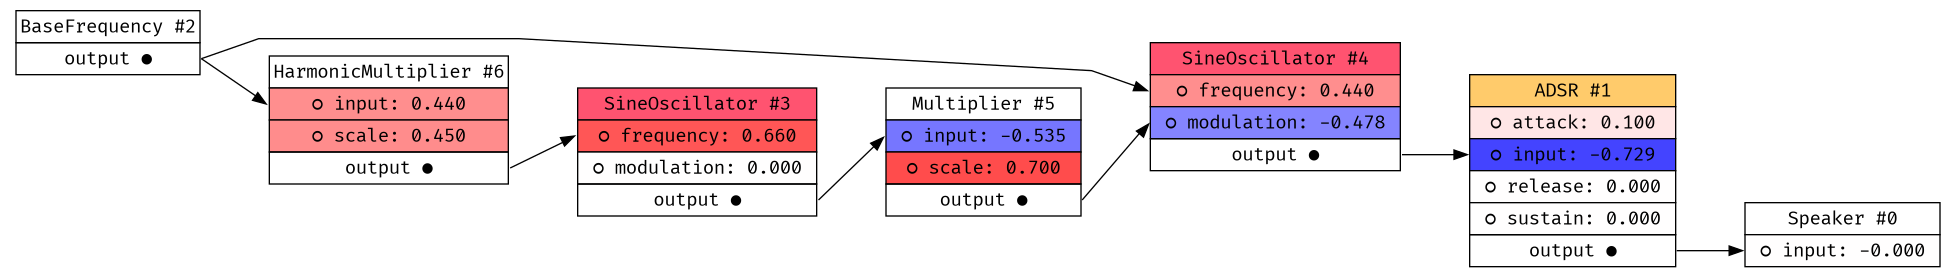

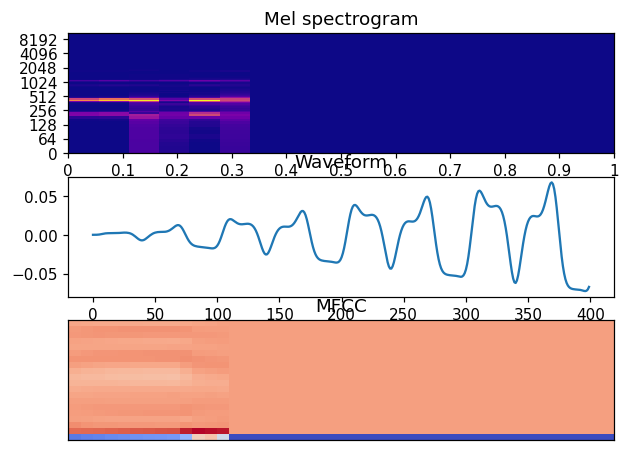

In [5]:
def one_operator_fm():
    graph = get_starting_graph()

    modulator = graph.add_node(SineOscillator())
    carrier = graph.add_node(SineOscillator())
    mod_index_scaler = graph.add_node(Multiplier())
    mod_freq_mult = graph.add_node(HarmonicMultiplier())
    
    graph.nodes[mod_index_scaler].inputs.scale = 0.70
    graph.nodes[mod_freq_mult].inputs.scale = 0.45
    graph.nodes[1].inputs.attack = 0.1
    graph.nodes[1].inputs.sustain = 0.0
    graph.nodes[1].inputs.release = 0.0

    graph.patch(carrier, "output", 1, "input")
    graph.patch(2, "output", carrier, "frequency")
    graph.patch(2, "output", mod_freq_mult, "input" )
    graph.patch(mod_freq_mult, "output", modulator, "frequency")
    graph.patch(modulator, "output", mod_index_scaler, "input")
    graph.patch(mod_index_scaler, "output", carrier, "modulation")
    
    return graph

target_graph = one_operator_fm()

target_audio = target_graph.play(num_samples = SAMPLE_RATE * 1)
display(Image(target_graph.draw()))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
target_audio.plot_spectrogram(ax1)
target_audio.plot_waveform(ax2)
target_audio.plot_mfcc(ax3)

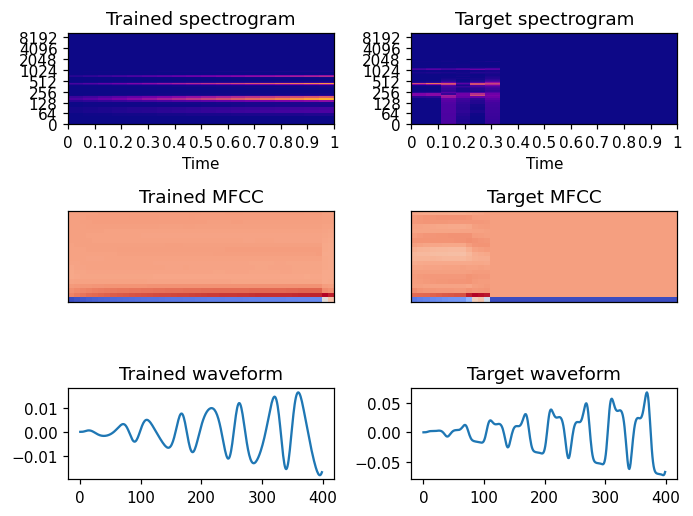

In [6]:
test_graph = one_operator_fm()

# mod index
test_graph.nodes[6].inputs.scale = 0.1

# mod freq
test_graph.nodes[1].inputs.attack = 0.99
test_graph.nodes[1].inputs.release = 0.0005

# attack
# test_graph.nodes[2].set_value(0.0001)

test_audio = test_graph.play(num_samples = SAMPLE_RATE * 1)
# display(Image(target_graph.draw()))

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

test_audio.plot_spectrogram(ax1, "Trained spectrogram")
test_audio.plot_waveform(ax5, title="Trained waveform")
test_audio.plot_mfcc(ax3, title="Trained MFCC")

target_audio.plot_spectrogram(ax2, title="Target spectrogram")
target_audio.plot_waveform(ax6, title="Target waveform")
target_audio.plot_mfcc(ax4, title="Target MFCC")
fig.tight_layout()

  0%|          | 0/21 [00:00<?, ?it/s]

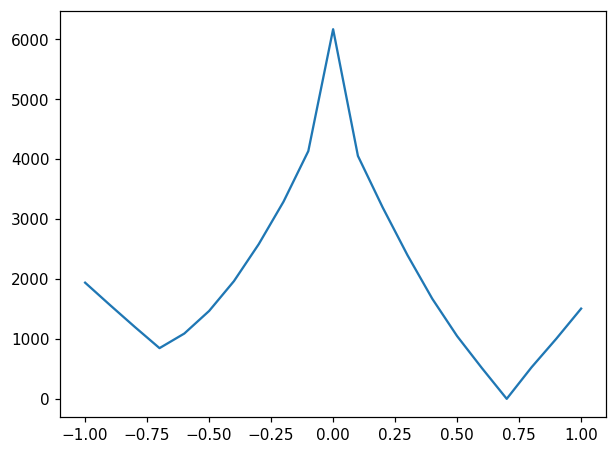

In [7]:
mod_strengths = [ a / 100 for a in range(-100, 101, 10) ]
# results = []

def get_distance_variable_mod_strength(strength):
    graph = one_operator_fm()
    graph.nodes[5].inputs.scale = strength
    generated_audio = graph.play(SAMPLE_RATE)
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_strength, mod_strengths), total=len(mod_strengths)))

plt.plot( mod_strengths, results )

  0%|          | 0/20 [00:00<?, ?it/s]

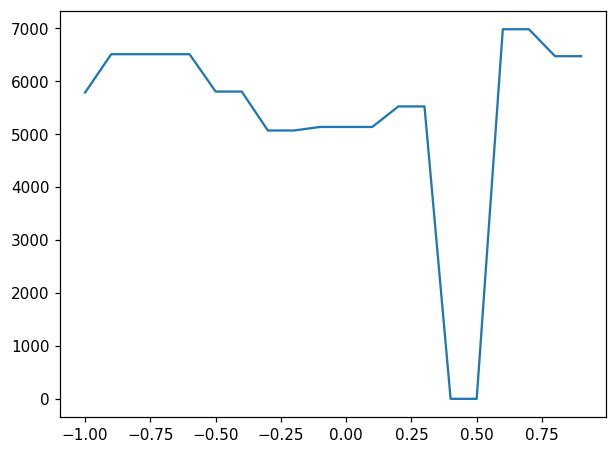

In [8]:
mod_freqs = [ a / 100 for a in range(-100, 100, 10) ]
results = []

def get_distance_variable_mod_freq(freq):
    graph = one_operator_fm()
    graph.nodes[6].inputs.scale = freq
    generated_audio = graph.play(SAMPLE_RATE)
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_freq, mod_freqs), total=len(mod_freqs)))
    
plt.plot( mod_freqs, results )

In [9]:
attack_values = [ a / 100 for a in range(-100, 100, 1) ]
results = []

def get_distance_variable_attack(attack):
    graph = one_operator_fm()
    graph.nodes[1].inputs.attack = attack
    generated_audio = graph.play(SAMPLE_RATE)
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_attack, attack_values), total=len(attack_values)))

plt.plot(attack_values, results)

  0%|          | 0/200 [00:00<?, ?it/s]

Process ForkPoolWorker-24:
Process ForkPoolWorker-19:
Process ForkPoolWorker-20:

KeyboardInterrupt



In [ ]:
STEP_VALUE = 20 # Lover means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.nodes[6].inputs.scale = freq
    graph.nodes[5].inputs.scale = mod_strength
    generated_audio = graph.play(SAMPLE_RATE * 1)

    dist = target_audio.mfcc_distance(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
fig.tight_layout()

In [ ]:
# target_audio = fm_sample

MAX_ITERATIONS = 25
POPULATION_SIZE = 35

def optimise_freq_and_mod(x):
    graph = one_operator_fm()
    graph.assign_params(x)
    # graph.nodes[10].set_value(x[1])
    # graph.nodes[graph.amp_attack].set_value(x[2])
    generated_audio = graph.play(SAMPLE_RATE)
    dist = target_audio.mfcc_distance(generated_audio)
    return dist

target_fun_values = []
def callback(x, convergence):
    clear_output()
    target_fun = optimise_freq_and_mod(x)
    target_fun_values.append(target_fun)
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = one_operator_fm().num_params()
solution = differential_evolution(optimise_freq_and_mod, [ (-1, 1) for i in range(num_params) ], workers=8, maxiter=MAX_ITERATIONS, popsize=POPULATION_SIZE, polish=False, callback=callback)
solution

# Show the result

graph = one_operator_fm()
graph.assign_params(solution.x)

generated_audio = graph.play(num_samples = SAMPLE_RATE * 1)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
generated_audio.plot_waveform(ax5, title="Trained waveform")
generated_audio.plot_mfcc(ax3, title="Trained MFCC")

target_audio.plot_spectrogram(ax2, title="Target spectrogram")
target_audio.plot_waveform(ax6, title="Target waveform")
target_audio.plot_mfcc(ax4, title="Target MFCC")

fig.tight_layout()

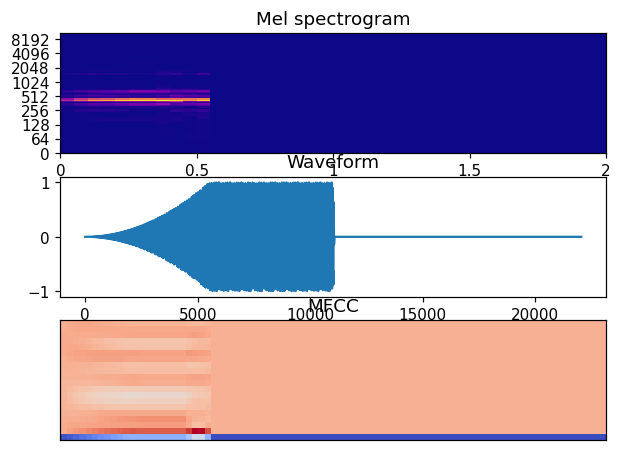

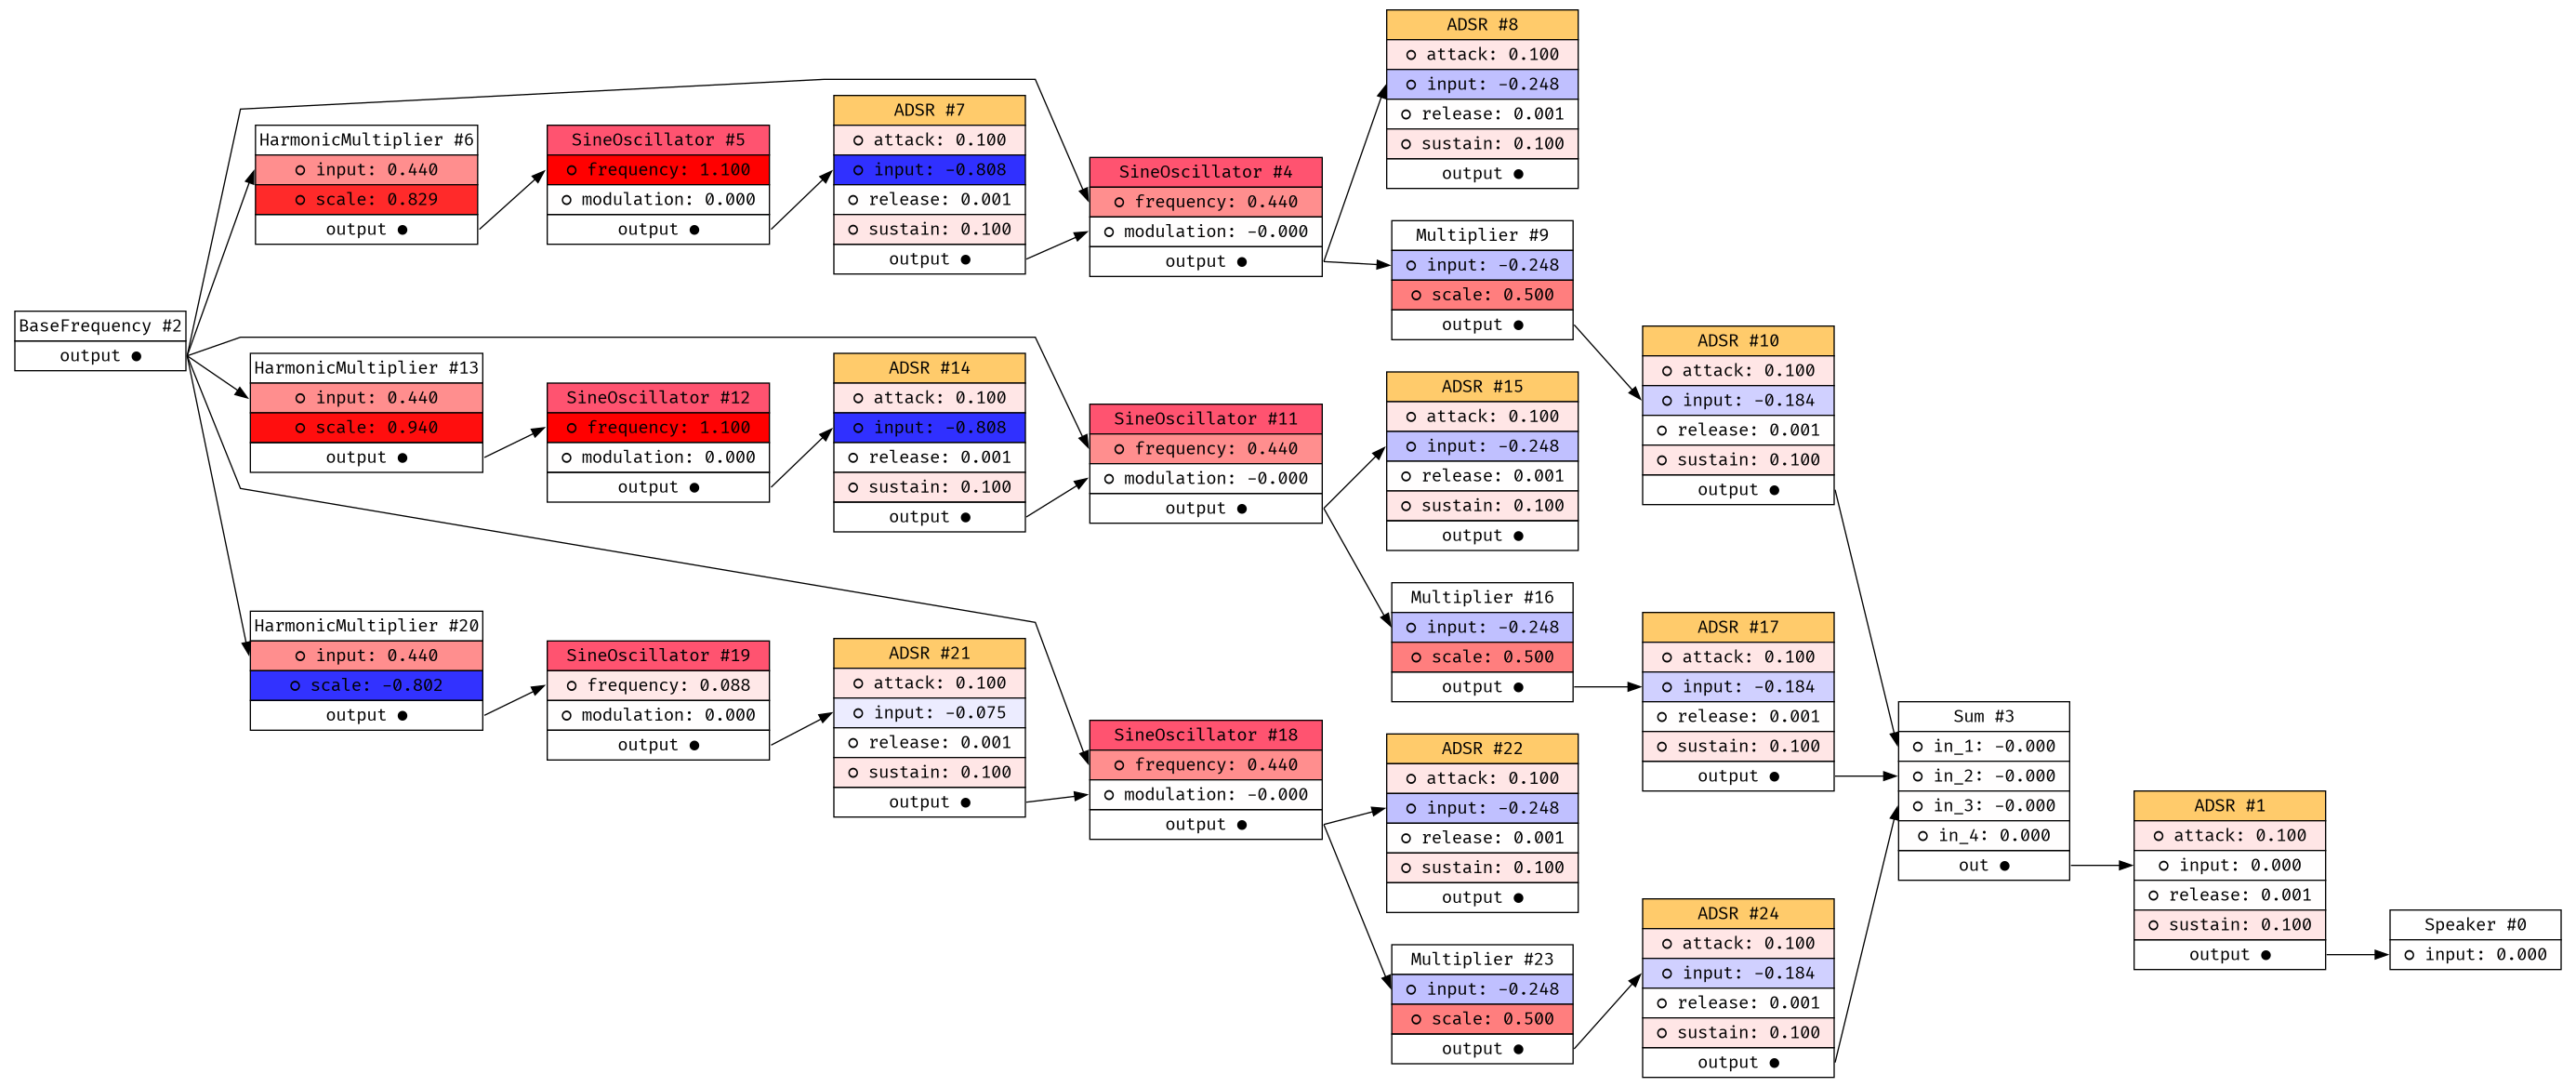

1.0
Distance 49951.19241339701


In [14]:
def multiplier_with_param(graph: DspGraph):
    mult = graph.add_node(Multiplier())
    return mult

def adsr_with_params(graph: DspGraph):
    adsr = graph.add_node(ADSR())
    return adsr

def oscillator_with_multiplier(graph: DspGraph):
    osc = graph.add_node(SineOscillator())
    mod_osc = graph.add_node(SineOscillator())
    
    mod_osc_freq_mult = graph.add_node(HarmonicMultiplier())
    graph.nodes[mod_osc_freq_mult].inputs.scale = random.uniform(-1.0, 1.0)
    
    graph.patch(2, "output", mod_osc_freq_mult, "input")
    graph.patch(2, "output", osc, "frequency")
    graph.patch(mod_osc_freq_mult, "output", mod_osc, "frequency")
    
    mod_adsr = adsr_with_params(graph)
    osc_adsr = adsr_with_params(graph)
    
    graph.patch(mod_osc, "output", mod_adsr, "input")
    graph.patch(osc, "output", osc_adsr, "input")
    
    graph.patch(mod_adsr, "output", osc, "modulation")
    mult = multiplier_with_param(graph)
    graph.patch(osc, "output", mult, "input")
    return mult


def oscillator_with_adsr(graph: DspGraph):
    mult = oscillator_with_multiplier(graph)
    adsr = adsr_with_params(graph)  
    graph.patch(mult, "output", adsr, "input")
    
    return adsr
    
def complex_fm():
    graph = get_starting_graph()
    mixer = graph.add_node(Sum())
    graph.patch(mixer, "out", 1, "input")

    osc_output_node = oscillator_with_adsr(graph)
    graph.patch(osc_output_node, "output", mixer, "in_1")

    osc_output_node = oscillator_with_adsr(graph)
    graph.patch(osc_output_node, "output", mixer, "in_2")

    osc_output_node = oscillator_with_adsr(graph)
    graph.patch(osc_output_node, "output", mixer, "in_3")
    
    return graph

graph = complex_fm()
    
# osc_output_node = oscillator_with_adsr(graph)
# graph.patch(osc_output_node, "output", mixer, "in_4")

from copy import deepcopy
best_graph = deepcopy(graph)

generated_audio = graph.play(SAMPLE_RATE * 2)
# generated_audio = graph.save_video(SAMPLE_RATE * 2)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_audio.plot_spectrogram(ax1)
generated_audio.plot_waveform(ax2, num_samples=SAMPLE_RATE)
generated_audio.plot_mfcc(ax3)
generated_audio.show_player()
plt.show()

display(Image(graph.draw()))
print(max(generated_audio.buffer))

lowest_dist = fm_sample.mfcc_distance(generated_audio)
print("Distance", lowest_dist)
distances = []

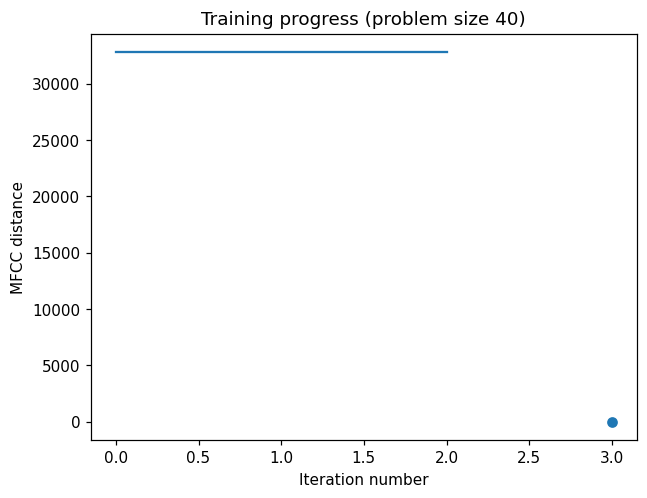

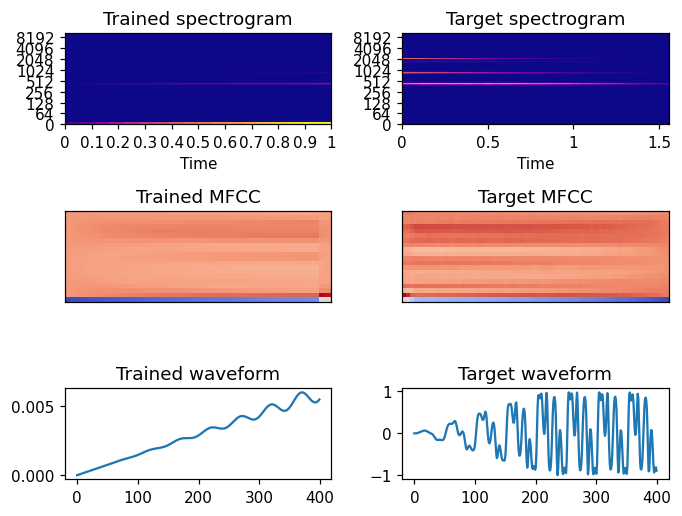

In [22]:
# target_audio = fm_sample
#one_operator_fm
MAX_ITERATIONS = 30
POPULATION_SIZE = 40

def optimise_freq_and_mod(x):
    graph = complex_fm()
    graph.assign_params(x)
    # graph.nodes[10].set_value(x[1])
    # graph.nodes[graph.amp_attack].set_value(x[2])
    generated_audio = graph.play(SAMPLE_RATE)
    try:
        dist = fm_sample.mfcc_distance(generated_audio)
    except Exception:
        return 9999999999
    
    return dist

target_fun_values = []
def callback(x, convergence):
    clear_output()
    target_fun = optimise_freq_and_mod(x)
    target_fun_values.append(target_fun)
    os.system(f"echo '{target_fun}' | tnb")
    os.system(f"echo '{str(x)}' | tnb")
    plt.plot(target_fun_values)
    plt.scatter(MAX_ITERATIONS, 0)
    plt.title(f"Training progress (problem size {len(x)})")
    plt.xlabel("Iteration number")
    plt.ylabel("MFCC distance")
    plt.show()

num_params = complex_fm().num_params()
solution = differential_evolution(optimise_freq_and_mod, [ (-1, 1) for i in range(num_params) ], workers=8, maxiter=MAX_ITERATIONS, popsize=POPULATION_SIZE, polish=False, callback=callback)
solution

# Show the result

graph = complex_fm()
graph.assign_params(solution.x)

generated_audio = graph.play(num_samples = SAMPLE_RATE * 1)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=False, sharey=False)

generated_audio.plot_spectrogram(ax1, "Trained spectrogram")
generated_audio.plot_waveform(ax5, title="Trained waveform")
generated_audio.plot_mfcc(ax3, title="Trained MFCC")

fm_sample.plot_spectrogram(ax2, title="Target spectrogram")
fm_sample.plot_waveform(ax6, title="Target waveform")
fm_sample.plot_mfcc(ax4, title="Target MFCC")

fig.tight_layout()

In [ ]:
evolved_graph = deepcopy(best_graph)
evolved_graph.assign_params(result.x)

generated_audio = evolved_graph.play(SAMPLE_RATE * 2)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
generated_audio.plot_spectrogram(ax1)
generated_audio.plot_waveform(ax2, num_samples=SAMPLE_RATE)
generated_audio.plot_mfcc(ax3)
generated_audio.show_player()
plt.show()

In [ ]:
# import time

# def randomize_calc_distance(graph_to_change):
#     for i in range(random.choice([0,1,5,10,15])):
#         modification = random.choice([
#             nudge_random_param,
#             randomize_random_param,
#             set_random_param_to_base_frequency,
#             set_random_param_to_one])
#         modification(graph_to_change)
        
#     graph_to_change_backup = deepcopy(graph_to_change)
#     generated_sample = graph_to_change.play(len(fm_sample))
#     dist = fm_sample.mfcc_distance(generated_sample)
    
#     if sum(abs(generated_sample.buffer)) == 0:
#         dist = float("inf")

#     return dist, graph_to_change_backup
    
# # raise ValueError("stop")
    
# with Pool() as p:
#     for i in tqdm(range(10000)):
        
#         graphs_to_modify = [deepcopy(best_graph) for _ in range(8)]
#         results = list(p.imap(randomize_calc_distance, graphs_to_modify))
#         dist, changed_graph = min(results, key=lambda r: r[0])
#         distances.append(dist)
        
#         found_new_best = False
#         if dist < lowest_dist:
#             found_new_best = True
#             best_graph = changed_graph
#             lowest_dist = dist
#             print("New best dist", dist)

#         if found_new_best or i % 10 == 0:
#             clear_output()
#             graph = deepcopy(best_graph)
#             generated_audio = graph.play(SAMPLE_RATE * 2)
#             # sf.write(
#             #     f"/home/wint3rmute/code/luthier/{int(time.time())}.wav",
#             #     generated_audio.buffer,
#             #     SAMPLE_RATE,
#             #     subtype='PCM_24'
#             # )

#             fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False, sharey=False)
#             generated_audio.plot_spectrogram(ax1)
#             generated_audio.plot_waveform(ax2, num_samples=800)
#             generated_audio.plot_mfcc(ax3)
#             generated_audio.show_player()
#             ax4.plot(distances)
#             fig.tight_layout()
#             plt.show()

#         # else:
#         print("iteration", i)